#  <center> Problem Set 1 (Perovskites) <center>
<center> Spring 2025 <center>
<center> 3.C01/3.C51, 7.C01/7.C51, 10.C01/10.C51, 20.C01/20.C51 <center>
<center> Due: Monday, April 7, 2025 at 3:00 PM ET. <center>

<b>Name:</b> Jack David Carson

<b>Kerberos ID:</b> jdcarson

### Instructions:

Put your code in the code blocks flagged with `############# Code ##########`.

Numerical answers yielded from running the code should be included in an Answer Block (see next cell).

We have provided print statements where numerical answers are expected.

Your answer should be contained in a variable which you defined either in the Answer Block or the Code Block.

When a qualitative answer is expected, place those comments as Markdown/Text cells; when asked for within Code blocks, you can write answer as code comments by placing a # before your answer.

Your Answer Block should look like the following:

In [68]:
########## Answer ############

ans = 2
print("My answer is: {}.".format(ans))

# My regressor over-fitted the training data, I need to add regularization

########## Answer ############

My answer is: 2.


## Imports

In [69]:
# import packages
import numpy as np
import sklearn
import pandas as pd
from sklearn.model_selection import train_test_split

# models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from torch.utils.data import Dataset, DataLoader
from sklearn import preprocessing
from torch import nn
import torch.nn.functional as F

# metrics
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter("ignore", category=ConvergenceWarning)
import torch
from tqdm import tqdm


# plotting style, you can choose your own parameters
import matplotlib

matplotlib.rcParams.update({'font.size': 15})
matplotlib.rc('lines', linewidth=3, color='g')
matplotlib.rcParams['axes.linewidth'] = 2.0
matplotlib.rcParams['axes.linewidth'] = 2.0
matplotlib.rcParams["xtick.major.size"] = 6
matplotlib.rcParams["ytick.major.size"] = 6
matplotlib.rcParams["ytick.major.width"] = 2
matplotlib.rcParams["xtick.major.width"] = 2
matplotlib.rcParams['text.usetex'] = False

In [70]:
# A helper function for students to produce plots
def plot_clf(model, X, y, title):

    '''
        A function to plot confusion matrix and ROC curve

        Args:
            model(classifier object): model object (e.g. RandomForestClassifier, LogisticRegression)
            X(np.array): feature set
            y(np.array): label set
            title(str): plot name

        Example Usage:
            plot_clf(model, X_test, y_test, "test")
    '''

    fig, [ax_roc, ax_conf] = plt.subplots(1, 2, figsize=(12, 6))
    fig.tight_layout()

    RocCurveDisplay.from_estimator(model, X, y, ax=ax_roc)
    ConfusionMatrixDisplay.from_estimator(model, X, y, ax=ax_conf)

    ax_roc.set_title('{} ROC'.format(title))
    ax_conf.set_title('{} Confusion Matrix'.format(title))

    plt.show()

## Grading guideline

- Didn't answer the question 0%
- Showed some attempts, but clearly didn't try enough: 25%
- Showed solid attempts (showed code) but does not answer the question directly: 50%
- Showed solid attempts and get the question wrong: 60-80%
- Showed solid attempts with some small mistakes: 80-90%
- Showed code and answered the questions correctly: 100%

# Overview:
In this PSET, you will:

* Learn the basics of processing your data and training a machine learning model with PyTorch:
    * Processing data, including exploring OHE vs. other featurization techniques
    * Formatting your data into a `Dataset` object and wrapping in a `DataLoader` instance
    * Implementation of a Multi-Layer Perception in `PyTorch`
    * Setting up a training and testing loop, and how to do evaluation
    * Using a GPU to accelerate training!
    * Find the best hyperparameters


* Learn how to build some simple architectures for **classification** and **regression**:
    * Train a logistic regression model with `scikit-learn` to _classify_ breast cancers based on metabolite abundance
    *  Train a random forest classifier on the same data
    * Train a MLP using `PyTorch` on the same data
    * Train a MLP with `PyTorch` to _regress_ perovskite hull energies from their compositions
    * Apply regularization techniques to avoid overfitting (L1 and L2)
    * Apply physical descriptor-based encoding to improve training performance


## Download required data

In [ ]:
# for 1st set of tasks: binary classification
# TODO: update the datapaths
! wget https://raw.githubusercontent.com/coleygroup/ML4MolEng/main/psets/ps1-nonbio/data/breastcancer_X.csv
! wget https://raw.githubusercontent.com/coleygroup/ML4MolEng/main/psets/ps1-nonbio/data/breastcancer_y.csv

# for 2nd set of tasks: regression of perovskite binding energies

! wget https://raw.githubusercontent.com/coleygroup/ML4MolEng/main/psets/ps1-nonbio/data/data_perov/mendeleev.csv
! wget https://raw.githubusercontent.com/coleygroup/ML4MolEng/main/psets/ps1-nonbio/data/data_perov/perov_train.csv
! wget https://raw.githubusercontent.com/coleygroup/ML4MolEng/main/psets/ps1-nonbio/data/data_perov/perov_val.csv
! wget https://raw.githubusercontent.com/coleygroup/ML4MolEng/main/psets/ps1-nonbio/data/data_perov/elements.npy

# Problem 1: Breast cancer classification from metabolite data

## 1.1 (5 points) Load and inspect the raw data

We have provided the code to load the dataset. Take a moment to understand what each line is doing. Briefly explain what each line of the code is doing by providing short comments below.

You will have to do it by yourself again in Problem 2.

In [72]:
p1_X = pd.read_csv("./breastcancer_X.csv", header='infer', index_col=0) # load the csv file into pandas with read_csv. the infer is the default grabing row0 of the csv as the headers for each column in the dataframe. index_col=0 specifies that pandas should not autoindex 0...n a column in the df, but rather use the column0 in csv as a column where each is specified
p1_y = pd.read_csv("./breastcancer_y.csv", header='infer', index_col=0) # same thing. get the labels as a 1-column dataframe

metabolite_name = p1_X.columns.tolist() # converts the p1_X dataframe object to a Index object (output of .columns) and subsequently to a numpy ndarray via .tolist() which is a more useful format

p1_X = p1_X.values # gets the raw float values contained in the dataset without the indexes or column labels
p1_y = p1_y.values # gets all of the binary classification values without header

Report how many examples are in this dataset and the number of features for each data point.

In [73]:
########## Answer ############
N_samples, N_features = p1_X.shape
print("There are {} samples.".format(N_samples))
print("There are {} features per sample.".format(N_features))

########## Answer ############

There are 1726 samples.
There are 136 features per sample.


## 1.2 (5 points) Generate train/test splits.
Generate and print the shapes of your four variables, `X_train`, `X_test`, `y_train`, and `y_test`, and ensure sure that the dimensions match your expectations.

In [98]:
########### Code #############
X_train, X_test, y_train, y_test = train_test_split(p1_X, p1_y, test_size=0.2)
########### Code #############

In [99]:
########## Answer ############

X_train_shape = X_train.shape
y_train_shape = y_train.shape
X_test_shape = X_test.shape
y_test_shape = y_test.shape


print("X_train shape: {}".format(X_train_shape))
print("y_train shape: {}".format(y_train_shape))

print("X_test shape: {}".format(X_test_shape))
print("y_test shape: {}".format(y_test_shape))

########## Answer ############

X_train shape: (168, 128)
y_train shape: (168, 1)
X_test shape: (43, 128)
y_test shape: (43, 1)


## 1.3 (5 points) Preprocess the data through scaling
Scale the dataset.

In [100]:
########### Code #############
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

########### Code #############

Print the mean/variance for each transformed feature.

In [101]:
########## Answer ############

train_mean = X_train_scaled.mean(0)
train_variance = X_train_scaled.std(0) ** 2

test_mean = X_test_scaled.mean(0)
test_variance = X_test_scaled.std(0) ** 2

print("The means of the transformed feature train set are {}".format(train_mean))
print("The variances of the transformed feature train set are {}".format(train_variance))
print("The means of the transformed feature test set are {}".format(test_mean))
print("The variances of the transformed feature test set are {}".format(test_variance))

########## Answer ############

The means of the transformed feature train set are [ 2.70947286e-15  1.71555891e-15  6.34413157e-16  1.25560937e-15
  6.56881956e-16  4.91670197e-16  6.96532779e-16 -1.36134490e-16
 -8.32667268e-17 -1.74265364e-15  2.04201735e-16  3.10598108e-16
  9.14612301e-16 -4.45410904e-16  1.14095241e-15 -2.27992228e-16
  9.57897782e-16 -3.10185079e-16 -2.25348840e-16 -2.01558347e-17
  1.06759839e-15  7.46757153e-16  4.68540550e-16  4.33515657e-16
  2.77886180e-16  1.02299122e-15  1.99575806e-16 -6.68777203e-16
 -9.25846701e-16 -4.23933375e-16 -1.79750394e-16 -4.99600361e-16
 -1.78428700e-16 -7.17679884e-16  2.51121875e-16  1.58338950e-15
  6.43665015e-16 -4.74488174e-16  8.98091125e-16 -1.10229286e-15
  1.81204258e-15  7.33540213e-17  4.33185234e-16 -1.12145742e-15
 -9.31794324e-16  1.04810340e-15 -3.31414790e-16 -5.51146430e-16
  1.24503582e-15  1.51994819e-16 -6.48125733e-16 -3.08615567e-16
  2.74912368e-16  1.36134490e-16  6.93889390e-18 -5.82867088e-16
  8.27556030e-17 -4.46732598e-16 -3.251


Q: Discuss the importance of not fitting the scaler transform on both train & test; why the transformed mean / variance between X_test_scaled & X_train_scaled may not be the same; and why this difference is potentially heartening.

**Your answer here:** If the test dataset has a different distribution than the train dataset, information about the standardization parameters of the test dataset could allow the model to cheat. Also, differing statistics indicate real-world distribution differences, ensuring a fairer, unbiased test.

## 1.4 (10 points) Training a logistic regression classifier with `scikit-learn`

`scikit-learn` has many handy simple machine learning frameworks that make it relatively simple to train, cross-validate, and tune a machine learning model that does not need to be heavily customized.


Below, train and evaluate a Logistic Regression model.

In [102]:
########### Code #############
# interesting. hadn't heard of ROC AUC before. good article here
# https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc
model = LogisticRegression()
model.fit(X_train_scaled, y_train.ravel())


train_auc = roc_auc_score(y_train, model.predict_proba(X_train_scaled)[:, 1])
test_auc = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])

########### Code #############

Report the AUC for both the train and test datasets.

In [103]:
########## Answer ############

print("The training AUC score is {:.3f}".format(train_auc) )
print("The testing AUC score is {:.3f}".format(test_auc) )

########## Answer ############

The training AUC score is 1.000
The testing AUC score is 0.996


Generate plots for the confusion matrices and the ROC curve for both training and testing. Please use the `plot_clf` function defined above.

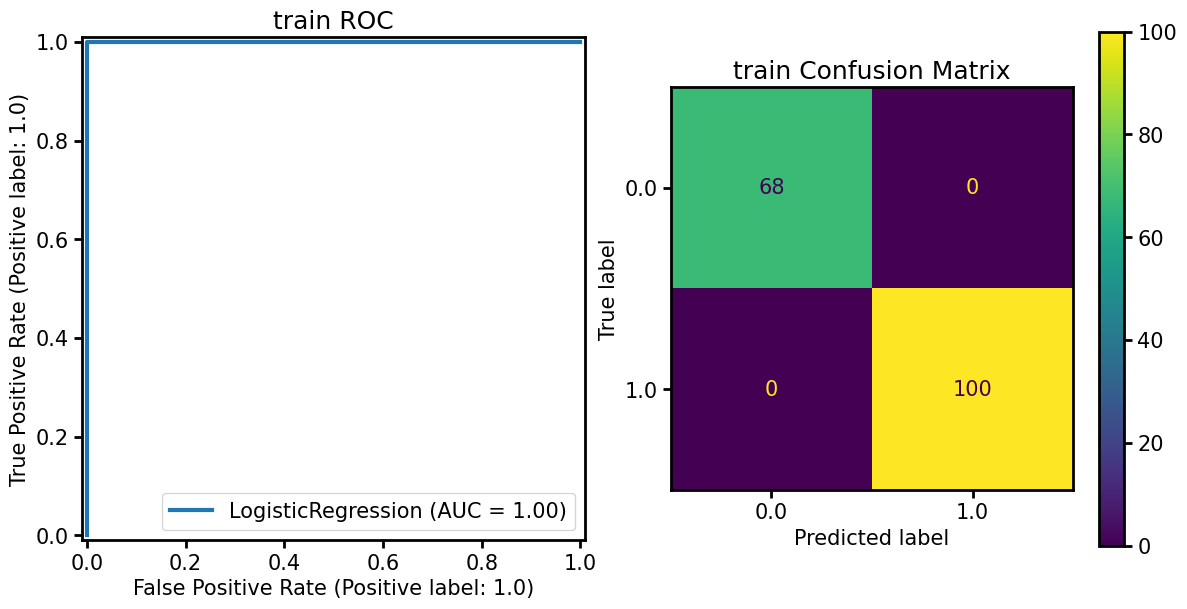

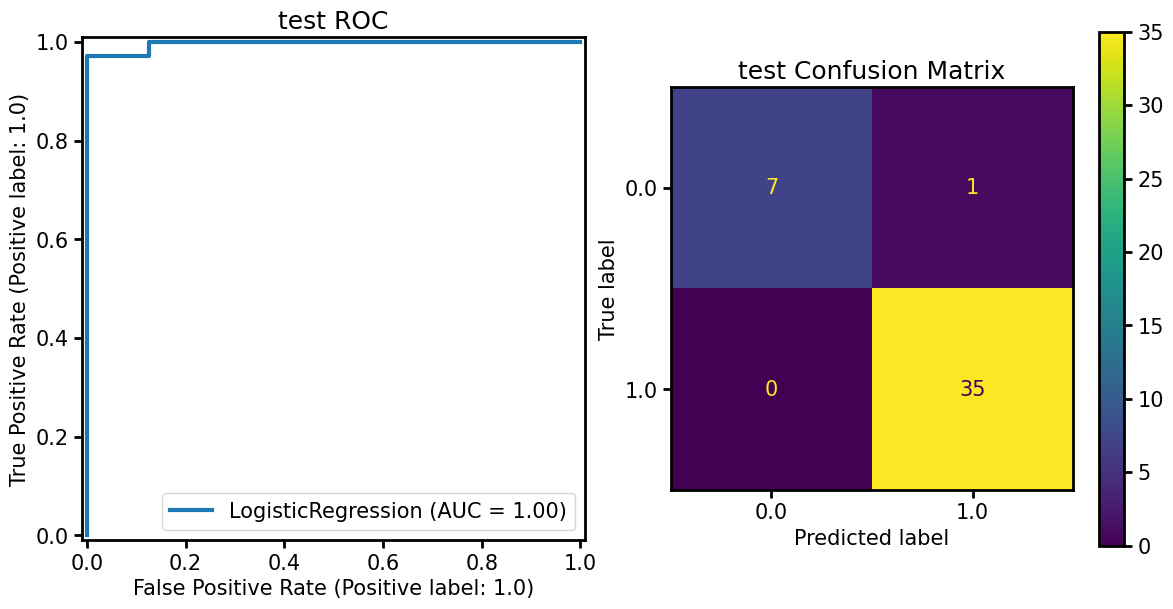

In [104]:
########### Code #############
plot_clf(model, X_train_scaled, y_train, "train")
plot_clf(model, X_test_scaled, y_test, "test")
########### Code #############

Generate a plot of the model coefficients' distribution using `plt.hist`.

(array([ 3.,  1.,  0.,  3.,  3.,  8.,  1.,  1.,  7.,  3., 12., 15.,  9.,
        19.,  8.,  7.,  6.,  4.,  2.,  5.,  7.,  1.,  0.,  1.,  2.]),
 array([-0.55693342, -0.51339675, -0.46986008, -0.42632342, -0.38278675,
        -0.33925008, -0.29571341, -0.25217674, -0.20864008, -0.16510341,
        -0.12156674, -0.07803007, -0.0344934 ,  0.00904326,  0.05257993,
         0.0961166 ,  0.13965327,  0.18318994,  0.2267266 ,  0.27026327,
         0.31379994,  0.35733661,  0.40087328,  0.44440994,  0.48794661,
         0.53148328]),
 <BarContainer object of 25 artists>)

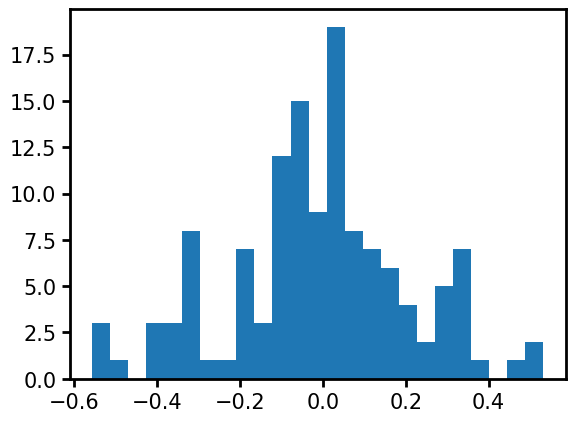

In [105]:
########### Code #############
plt.hist(model.coef_[0], bins=25)
########### Code #############

## 1.5 (5 points) Introduce L1 regularization
Modify the LogisticRegression call made to run L1-regularized logistic regression.

In [106]:
########### Code #############
model_l1 = LogisticRegression(penalty='l1', solver='saga')
model_l1.fit(X_train_scaled, y_train.ravel())

train_auc = roc_auc_score(y_train, model_l1.predict_proba(X_train_scaled)[:, 1])
test_auc = roc_auc_score(y_test, model_l1.predict_proba(X_test_scaled)[:, 1])
########### Code #############

Report the ROC-AUC score.

In [107]:
########## Answer ############


print("The training AUC score is {:.2f}".format(train_auc) )
print("The testing AUC score is {:.2f}".format(test_auc) )

########## Answer ############

The training AUC score is 1.00
The testing AUC score is 1.00


Correspondingly, generate the new confusion matrix and ROC curve.

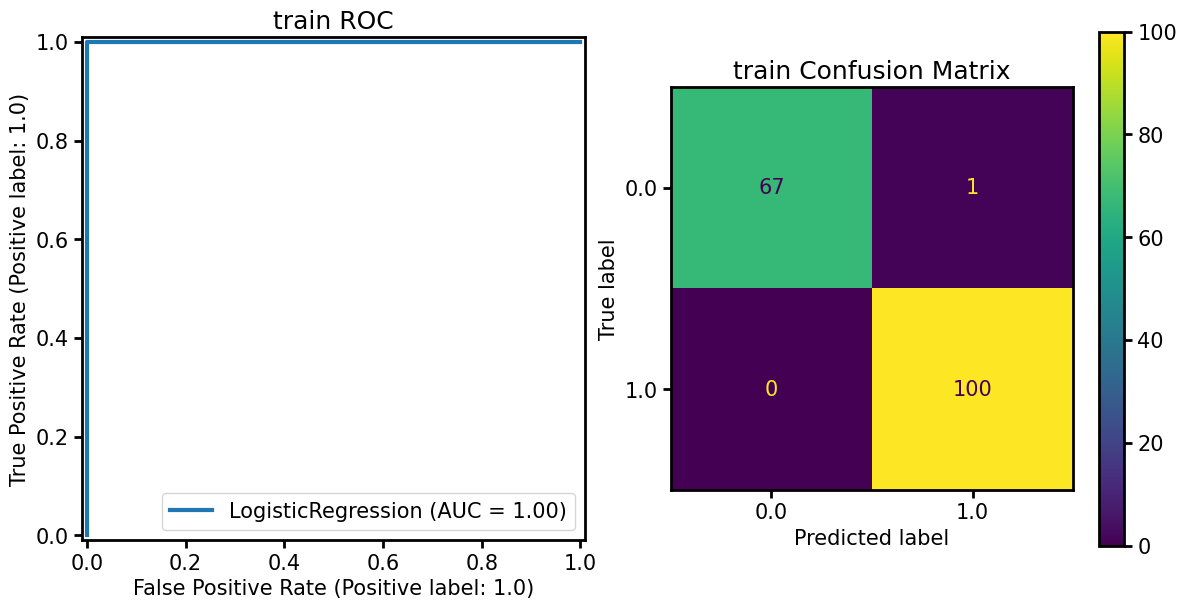

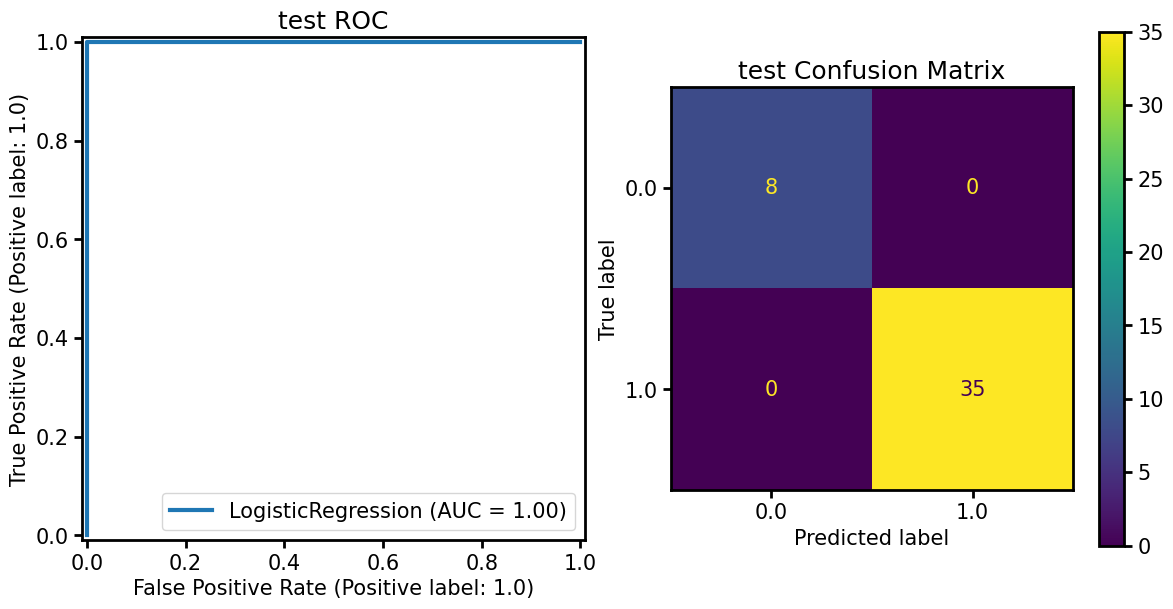

In [108]:
########### Code #############
plot_clf(model_l1, X_train_scaled, y_train, "train")
plot_clf(model_l1, X_test_scaled, y_test, "test")

########### Code #############

Plot the new distribution of model coefficients.

(array([ 1.,  0.,  0.,  1.,  1.,  1.,  0.,  3.,  3.,  2.,  2.,  3.,  1.,
        89.,  4.,  3.,  5.,  2.,  1.,  1.,  2.,  1.,  0.,  0.,  2.]),
 array([-0.81416838, -0.75527235, -0.69637631, -0.63748027, -0.57858423,
        -0.51968819, -0.46079215, -0.40189612, -0.34300008, -0.28410404,
        -0.225208  , -0.16631196, -0.10741592, -0.04851989,  0.01037615,
         0.06927219,  0.12816823,  0.18706427,  0.24596031,  0.30485634,
         0.36375238,  0.42264842,  0.48154446,  0.5404405 ,  0.59933654,
         0.65823258]),
 <BarContainer object of 25 artists>)

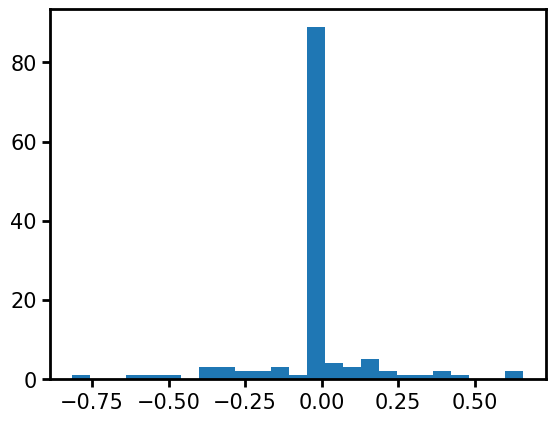

In [109]:
########### Code #############
plt.hist(model_l1.coef_[0], bins=25)

########### Code #############

Comment on the histogram you obtained, by comparing it to the one generated from the unregularized model's coefficients.

**Your answer here** According to the sklearn docs, the linear classifier uses by default the cross-entropy loss. The L1 penalty term adds a special penalty to this loss function
$$\cal{L}_{\text{cross-ent}}(\cdot) + \lambda \|w\|_1$$
for model weights $w$. This penalizes the sum of the model weights in the loss, encouraging the model to collapse its weights as small as possible.

In the original model, we see a roughly normal distribution. If the model weights are initialized normally, and most metabolites do not contribute much information to the classification $\nabla \theta_{\text{irrelevant}} \approx 0$ the distribution will remain roughly the same since most weight values simply aren't changing.

Alternatively with the L1 norm, the useless metabolites are encouraged to collapse their weight to 0, since it doesn't effect the cross-entropy loss, and lowers the L1 norm of the weights term.

## 1.6  (optional +2.5 points) Connect model coefficients back to metabolites

Code to identify the top 5 metabolites that positively correlated the most with positive diagnosis.

In [110]:
########### Code #############

top5_idx = np.argsort(model.coef_[0])[-5:]
metabolites = [metabolite_name[i] for i in top5_idx] # ez

########### Code #############

Report the metabolites you identified.

In [111]:
########## Answer ############

print("The top 5 metabolites are {}".format(", ".join(metabolites)) )

########## Answer ############

The top 5 metabolites are Myo-Inositol, 2,2'-Bipyridine, 1,2-dimethylpropanol, L-Homoserine, 2-Butenedioic acid


## 1.7 (5 points) Hyperparameter tuning the regularization parameter
Scan over the following regularization values `C=[0.01, 1, 5, 10]` (in `scikit-learn`, the regularization parameter `C` is inversely related to the regularization strength) and report which one yields the best performance (with the AUROC metric) on the train dataset. What is its performance on the test data?

In [112]:
########### Code #############

best_value = None
best_metric = 0
C_values = [0.01, 1, 5, 10]
for c in C_values:
    model = LogisticRegression(C=c)
    model.fit(X_train_scaled, y_train.ravel())
    train_auc = roc_auc_score(y_train, model.predict_proba(X_train_scaled)[:, 1])
    test_auc = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])
    print(test_auc)
    if test_auc > best_metric:
        best_metric = test_auc
        best_value = c

########### Code #############

1.0
0.9964285714285714
0.9964285714285714
0.9964285714285714


In [113]:
########### Answer #############

print(f"Best value: C = {best_value}")
# Performance on test AUC:
print("The hyperparameterized model's test AUC score is {:.2f}".format(test_auc) )

########### Answer #############

Best value: C = 0.01
The hyperparameterized model's test AUC score is 1.00


**Your answer here** Right now, C=0.01. However, all the models have a near-perfect classification. Originally, when running this I got C=1 with a different randomly generated train-test split. All these are ~0.001 difference, so there doesn't appear to be a major benefit

## 1.8 (5 points) Training a random forest classifier with `scikit-learn`

To minimize the variance of our method to reduce error arising from epistemic error (that is, from a set of limited data), we may often look to train multiple copies of a machine learning model, i.e., an _ensemble_ machine learning method.

Here, train a Random Forest classifier, which is an ensemble of decision trees. Random Forests, empirically, work really well on tabular data, but can be known to overfit easily. To mitigate this concern, also perform cross validation.

In [115]:
########### Code #############
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score


scaler = scaler# fill this in (reusing your scaler implementation from 1.3)
model = RandomForestClassifier(max_depth=2, n_estimators=20)
pipeline = Pipeline([('scaler', scaler), ('model', model)])

# Now call cross_val_score() and feed it: your pipeline as the estimator
# and your data (p1_X & p1_y) letting cross_val_score() handle the test / train split for you.

scores = cross_val_score(pipeline, p1_X, p1_y.ravel(), cv=5, scoring='roc_auc')
########### Code #############

Report the cross-validated ROC-AUC score.

In [116]:
########## Answer ############


print("The mean of CV scores is {:.2f}".format(mean) )
print("The std of CV scores is {:.2f}".format(std) )

########## Answer ############

The mean of CV scores is 0.94
The std of CV scores is 0.06


# Problem 2: Training a Multi-Layer Perceptron (MLP) to predict perovskite energies
## 2.1: (5 points) Encoding the data

For this second task, we will utilize perovskite data to predict their $E_{hull}$ values. Before we can build a model, we need to process the data by one-hot encoding the perovskites based on their elements.

Generate the X matrix and y vector from processing `perov_train` and `perov_test` appropriately (do not run any inference on `perov_test` until Part 2.5, but it's helpful to process it the same way here for consistency). Hint: Note that the one-hot encoding we perform should still give us a 2D matrix of `n_samples` x `n_features`, but now `n_features` will be different from the number of features originally.

In [276]:
from sklearn.preprocessing import LabelBinarizer

perov_train = pd.read_csv("perov_train.csv") # read train
perov_test = pd.read_csv("perov_val.csv") # read test
all_elements = np.load('./elements.npy', allow_pickle=True) # Read all elements


# Your code to featurize elements
########### Code #############

lb = LabelBinarizer()
lb.fit(all_elements)

X_train_full = np.concatenate([lb.transform(perov_train["A"]), lb.transform(perov_train["B"])], axis=1)
y_train_full = perov_train["e_above_hull"].values

X_test_full = np.concatenate([lb.transform(perov_test["A"]), lb.transform(perov_test["B"])], axis=1)
y_test_full = perov_test["e_above_hull"].values


scaler_y = StandardScaler()
y_train_full = scaler_y.fit_transform(perov_train["e_above_hull"].values.reshape(-1, 1)).ravel()  # Reshape and ravel
y_test_full = scaler_y.transform(perov_test["e_above_hull"].values.reshape(-1, 1)).ravel()  # Reshape and ravel


X, y = X_train_full, y_train_full
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

########### Code #############

Report the number of samples, number of features, and the number of possible values for one (not yet one-hot-encoded) feature you might have.

In [299]:
########## Answer ############
N_samples, N_features = X.shape
N_feat_vals = len(set(perov_train["A"])) ** 2 # just num elements sampling  twice with replacement from all elems in 'A'. the set for 'A' and 'B' are equal, so just ** 2 cos i'm lazy but wait i've typed more in this comment than it would take argh.
print("There are {} samples.".format(N_samples))
print("There are {} features per sample.".format(N_features))
print("There are {} possible values for one feature.".format(N_feat_vals))

########## Answer ############

There are 1726 samples.
There are 146 features per sample.
There are 4624 possible values for one feature.


## Check GPU usage

In [281]:
# Check if your GPU is requested successfully or not
assert torch.cuda.device_count() != 0

To work with GPU-accelerated training, we need to use `PyTorch`'s `Tensor` objects, which can help us manage CPU vs. GPU usage.

Demonstrate moving this sample tensor to and from the GPU.

In [300]:
numpy_sample = np.zeros((3, 5))
tensor_sample = torch.Tensor(numpy_sample)
print(tensor_sample.device)

###
tensor_sample = tensor_sample.to('cuda')
print(tensor_sample.device)
tensor_sample = tensor_sample.to('cpu')
print(tensor_sample.device)


### lol so necessary

cpu
cuda:0
cpu


## Build Datasets and DataLoaders in PyTorch

Below, we provide you with an example of a `Dataset` instance, the `SequenceDataset` class, to format your data.

Note that tensors are not moved onto the GPU at initialization or inside `__getitem__`; GPU memory is typically far more limited than CPU-available memory. To prevent out-of-memory errors, we typically minimize the amount of data on the GPU at any time. During `.forward()`, the easiest way to do this is by only putting one batch at a time on the GPU.

In [301]:
# Generate dataset
class PerovskiteDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.Tensor(np.array(X))  # store X as a pytorch Tensor
        self.y = torch.Tensor(np.array(y))  # store y as a pytorch Tensor
        self.len=len(self.X)                # number of samples in the data

    def __getitem__(self, index):
        return self.X[index], self.y[index] # get the appropriate item

    def __len__(self):
        return self.len

Use the above `Dataset` object to make train, validation, and test `PervoskiteDataset` objects, then wrap each in a `DataLoader` object. Here are some handy arguments you can use to tweak the DataLoader object:
* `batch_size`: the number of examples that your model will see during one forward/backward call.
* `shuffle`: whether or not to shuffle your data between epochs; if it is set to True, then each epoch's batches will be different in identity.
* `num_workers`: useful for when you have a lot of data to load in when making a batch; this allows you to multiprocess batch formation before they are used in forward calls on the GPU. it won't make much difference in this homework, but can be handy down the line :)

In [284]:
########### Code #############
X_subtrain, X_val, y_subtrain, y_val = train_test_split(X_train, y_train, test_size=0.2)

train_data = PerovskiteDataset(X_subtrain, y_subtrain)
val_data = PerovskiteDataset(X_val, y_val)
# The issue is likely here, test_data should be created from X_test_full and y_test_full
# to be consistent with the previous usage.
test_data = PerovskiteDataset(X_test_full, y_test_full) # changed to X_test_full, y_test_full

batch_size = 128
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)


########### Code #############

Run this cell to check that your DataLoaders work as expected.

In [285]:
########### Code #############

for loader in [train_dataloader, val_dataloader, test_dataloader]:
    for index, batch in enumerate(loader):
        # Your batch returns a X, y stacked in a batch
        X_batch, y_batch = batch[0], batch[1]
        print(X_batch.shape, y_batch.shape)
    print()

########### Code #############

torch.Size([128, 146]) torch.Size([128])
torch.Size([128, 146]) torch.Size([128])
torch.Size([128, 146]) torch.Size([128])
torch.Size([128, 146]) torch.Size([128])
torch.Size([128, 146]) torch.Size([128])
torch.Size([128, 146]) torch.Size([128])
torch.Size([128, 146]) torch.Size([128])
torch.Size([128, 146]) torch.Size([128])
torch.Size([80, 146]) torch.Size([80])

torch.Size([128, 146]) torch.Size([128])
torch.Size([128, 146]) torch.Size([128])
torch.Size([20, 146]) torch.Size([20])

torch.Size([128, 146]) torch.Size([128])
torch.Size([82, 146]) torch.Size([82])



There should be 11 training set batches, 3 validation batches, and 2 test batches, with sizes shown above. Each set has an final, impartial batch.

## 2.2 (10 points) Define the MLP in PyTorch

Look at the following code snippet to understand how the linear layer works in PyTorch. Take careful note of the dimensions of the input and output.

In [286]:
linear = torch.nn.Linear(2, 3)

input_tensor = torch.ones((4, 2))
output_tensor = linear(input_tensor)

print(input_tensor, output_tensor, input_tensor.shape, output_tensor.shape)

tensor([[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]]) tensor([[-0.6846, -0.6184, -0.6187],
        [-0.6846, -0.6184, -0.6187],
        [-0.6846, -0.6184, -0.6187],
        [-0.6846, -0.6184, -0.6187]], grad_fn=<AddmmBackward0>) torch.Size([4, 2]) torch.Size([4, 3])


Look at the following code snippet to understand how the ReLU layer works in PyTorch (the Tanh layer is similar). Take careful note of the dimensions of the input and output.

In [287]:
relu = torch.nn.ReLU()

input_tensor = torch.ones((4, 2))
output_tensor = relu(input_tensor)

print(input_tensor, output_tensor, input_tensor.shape, output_tensor.shape)

tensor([[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]]) tensor([[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]]) torch.Size([4, 2]) torch.Size([4, 2])


Look at the following code snippet to understand how to stack layers with the Sequential module.

In [288]:
layer1 = torch.nn.Linear(2, 3)
layer2 = torch.nn.Linear(3, 4)

sequential = torch.nn.Sequential(layer1, layer2)

input_tensor = torch.ones((5, 2))
output_tensor = sequential(input_tensor)

print(input_tensor, output_tensor, input_tensor.shape, output_tensor.shape)

tensor([[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]]) tensor([[-0.7268,  0.2862,  0.1940,  0.3088],
        [-0.7268,  0.2862,  0.1940,  0.3088],
        [-0.7268,  0.2862,  0.1940,  0.3088],
        [-0.7268,  0.2862,  0.1940,  0.3088],
        [-0.7268,  0.2862,  0.1940,  0.3088]], grad_fn=<AddmmBackward0>) torch.Size([5, 2]) torch.Size([5, 4])


Build your MLP within the following torch.nn.Module object.

In [290]:
########### Code #############
class PerovMLP(torch.nn.Module):
    def __init__(self, in_features=146, hidden_dim=256, num_layers=3, activation=nn.Tanh()):
        # You may either modify the above __init__ call to either take in hyperparameters as keyword arguments,
        # or hard-code them below. If you want to do hyperparameter search, then modifying to take in
        # keyword arguments is recommended.
        super().__init__()
        ########### Code #############

        # Implement your code here
        layers_list = [] # changed name to layers_list for clarity, and to prevent collision with num_layers argument
        layers_list.append(nn.Linear(in_features, hidden_dim))
        layers_list.append(activation)

        for _ in range(num_layers - 1): # using num_layers arg here
            layers_list.append(nn.Linear(hidden_dim, hidden_dim))
            layers_list.append(activation)

        layers_list.append(nn.Linear(hidden_dim, 1)) # output is 1d scalars

        self.model = nn.Sequential(*layers_list) # passing the list of layers here
        ########### Code #############



    def forward(self, x):
        x = self.model(x)

        return x

########### Code #############

## 2.3 (10 points) Implement functions for training and testing

We define your device, model, and epochs; fill in the optimizer and loss function. For the optimizer, use an L2 weight of 0.01 and the Adam optimizer.

In [320]:
########### Code #############

# device to train on
device = 'cuda:0'
# define your model
model = PerovMLP(in_features=146, num_layers=3).to(device)

# define your optimizer
optimizer = optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.01)

# define your loss function
loss_fn = torch.nn.MSELoss() # just generic

# define number of epochs
epochs = 250

########### Code #############

Implement your training and validation loops here.

In [321]:
########### Code #############

def train(model, dataloader, optimizer, loss_fn, device):

    '''
    A function train on the entire dataset for one epoch.

    Args:
        model (torch.nn.Module): your model from before
        dataloader (torch.utils.data.DataLoader): DataLoader object for the train data
        optimizer (torch.optim.Optimizer(()): optimizer object to interface gradient calculation and optimization
        device (str): Your device (usually 'cuda:0' for your GPU)

    Returns:
        float: loss averaged over all the batches
    '''

    epoch_loss = []
    model.train() # Set model to training mode

    for batch in dataloader:
        X, y = batch
        X = X.to(device)
        y = y.to(device)

        # train your model on each batch here
        y_pred = model(X)

        ########### Code #############
        optimizer.zero_grad()
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())
        ########### Code #############

    epoch_mean = sum(epoch_loss) / len(epoch_loss)
    return epoch_mean



def validate(model, dataloader, loss_fn, device):

    '''
    A function validate on the validation dataset for one epoch.

    Args:
        model (torch.nn.Module): your model for before
        dataloader (torch.utils.data.DataLoader): DataLoader object for the validation data
        device (str): Your device (usually 'cuda:0' for your GPU)

    Returns:
        float: loss averaged over all the batches

    '''

    val_loss = []
    model.eval() # Set model to evaluation mode
    with torch.no_grad():
        for batch in dataloader:
            X, y = batch
            X = X.to(device)
            y = y.to(device)

            # validate your model on each batch here
            y_pred = model(X)

            ########### Code #############
            loss = loss_fn(y_pred, y)
            val_loss.append(loss.item())
            ########### Code #############

    epoch_mean = sum(val_loss) / len(val_loss)
    return epoch_mean
########### Code #############


Train and validate your model.

In [322]:
########### Code ###########
val_loss_curve = []
train_loss_curve = []

def update(progress_bar, train_loss, val_loss):
    progress_bar.set_postfix({"train_loss": train_loss, "val_loss": val_loss})

progress_bar = tqdm(range(epochs)) # this wraps your iteration in a handy progress bar to track any metrics.

for epoch in progress_bar:

    # Train your model on training data
    train_loss = train(model, train_dataloader, optimizer, loss_fn=loss_fn, device=device)

    # Validate your model on validation data
    val_loss = validate(model, val_dataloader, loss_fn=loss_fn, device=device)

    # Record train and loss performance
    train_loss_curve.append(train_loss)
    val_loss_curve.append(val_loss)

    update(progress_bar, train_loss, val_loss)
########### Code ###########

100%|██████████| 250/250 [00:07<00:00, 32.77it/s, train_loss=1, val_loss=1.17]


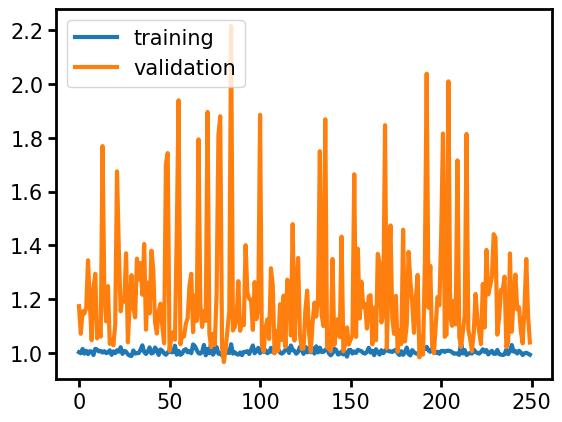

In [319]:
plt.plot(train_loss_curve, label="training")
plt.plot(val_loss_curve, label="validation")
plt.legend()

Multi-Layer Perceptron training R^2 score: -0.00
Multi-Layer Perceptron validation R^2 score: -0.00


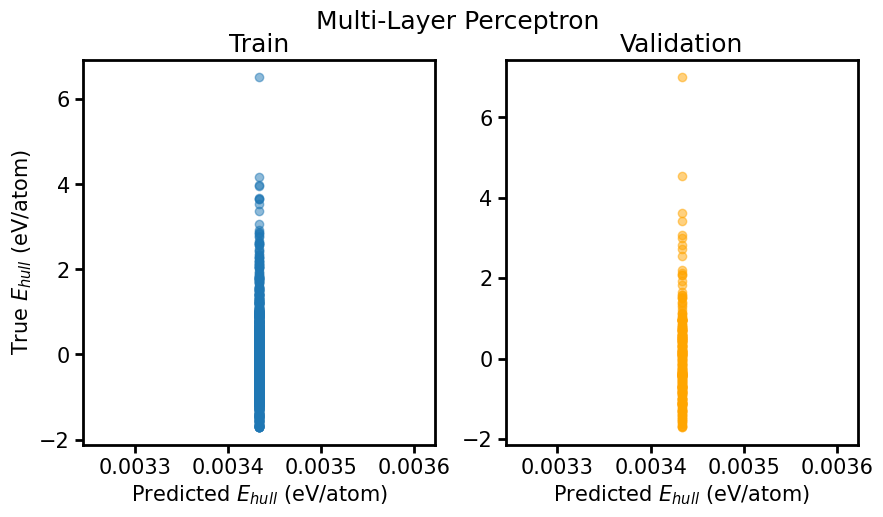

In [295]:
########### Code #############
from sklearn.metrics import r2_score

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

yhat_train = model(torch.tensor(X_subtrain).float().to(device)) # Changed X_train to X_subtrain to match y_subtrain
yhat_val = model(torch.tensor(X_val).float().to(device))

yhat_train = yhat_train.cpu().detach().numpy()
yhat_val = yhat_val.cpu().detach().numpy()

ax[0].scatter(yhat_train, y_subtrain, label='Train', alpha=0.5)
ax[1].scatter(yhat_val, y_val, label='Test', alpha=0.5, c='orange')

ax[0].set_ylabel("True $E_{hull}$ (eV/atom)")
ax[0].set_xlabel("Predicted $E_{hull}$ (eV/atom)")
ax[1].set_xlabel("Predicted $E_{hull}$ (eV/atom)")
ax[0].set_title('Train')
ax[1].set_title('Validation')
fig.suptitle('Multi-Layer Perceptron')

print("Multi-Layer Perceptron training R^2 score: {:.2f}".format(r2_score(y_subtrain, yhat_train)))
print("Multi-Layer Perceptron validation R^2 score: {:.2f}".format((r2_score(y_val, yhat_val))))

########### Code #############

In [239]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)
yhat_lr = reg.predict(X_train)
print("Train R^2:", r2_score(y_train, yhat_lr))


Train R^2: 0.7101416728936156


In [240]:
X_train

array([[-0.10482848, -0.14126448, -0.08102192, ...,  0.        ,
        -0.11815381, -0.1613143 ],
       [-0.10482848, -0.14126448, -0.08102192, ...,  0.        ,
        -0.11815381, -0.1613143 ],
       [-0.10482848, -0.14126448, -0.08102192, ...,  0.        ,
        -0.11815381, -0.1613143 ],
       ...,
       [-0.10482848, -0.14126448, -0.08102192, ...,  0.        ,
        -0.11815381, -0.1613143 ],
       [-0.10482848, -0.14126448, -0.08102192, ...,  0.        ,
        -0.11815381, -0.1613143 ],
       [-0.10482848, -0.14126448, -0.08102192, ...,  0.        ,
        -0.11815381, -0.1613143 ]])

## 2.4 (5 points) (grad) Calculate model size

Calculate the total of number of parameters in your MLP model. What does the input hidden_layers_sizes = (256, 256, 256) mean?

In [ ]:
########## Answer ############


########## Answer ############

Your answer here

## 2.5 (5 points) Chemical Transferability of One-Hot Representations

In [ ]:
########### Code #############

# Load the test dataset which contains elements not seen in the training data
perov_test = pd.read_csv("perov_val.csv")

# Your code to preprocess data and predict on this test dataset, including a scatterplot of predictions





print("MLP validation R^2 score: {:.2f}".format(r2_score(y_test, yhat_test)))
########### Code #############

Comment on your validation results and briefly explain.

Your answer here

## 2.6 (10 points) (grad) Featurize perovskites with physical descriptors

In [ ]:
########### Code #############
elements_pd = pd.read_csv("mendeleev.csv")
elements_pd = elements_pd.set_index('symbol')







########### Code #############

In [ ]:
########### Code #############

# New dataloaders needed
new_train_data = PerovskiteDataset(X_atom_train, y_atom_train)
new_train_dataloader = DataLoader(new_train_data, batch_size=batch_size, shuffle=True)

new_val_data = PerovskiteDataset(X_atom_val, y_atom_val)
new_val_dataloader = DataLoader(new_val_data, batch_size=batch_size, shuffle=True)

# Fill in the rest





print("Retrained MLP Training R^2 score: {:.2f}".format(r2_score(y_atom_train, yhat_new_train)))
print("Retrained MLP Validation R^2 score: {:.2f}".format(r2_score(y_atom_val, yhat_new_val)))

########### Code #############

## 2.7 (10 points) (grad) Chemical transferability of Physical Descriptors

In [ ]:
########### Code #############


print("Retrained MLP Testing R^2 score: {:.2f}".format(r2_score(y_test, yhat_test)))

########### Code #############

Briefly comment on your validation and explain why.

Your answer here.

You've reached the end! Upon completing your pset, note any collaborators or assistance from AI tools in a cell below; and submit to Gradescope [here](https://www.gradescope.com/courses/1011324/assignments/6007173/).